# Data Augmentation
---
- CNN을 포함한 딥러닝 모델은 Graphical Feature를 학습시키는 것이 주목적이고, 복잡한 문제를 풀기 위한 복잡한 모델이 대부분임. 
- 복잡한 모델을 만들기 위해서는 다량의 데이터가 필요하지만, 데이터는 한정적임. 이를 보완하기 위한 방법이 **Data Augmentation**임. 
- 데이터를 임의로 변형해 데이터의 수를 늘려 다양한 Feature를 뽑는 방법을 Data Augmentation이라고 함. 
- 일반적으로 이미지 분류 문제에서 Data Augmentation을 할 경우에 성능이 소폭 상승한다고 알려져 있음. 

### Random Flip / Rotation / Crop / Scaling
- Random Flip : 이미지를 랜덤하게 좌우 또는 상하 반전
- Rotation : 이미지 회전
- Crop : 이미지의 일정 부분을 잘라서 사용
- Scaling : 이미지를 확대 또는 축소

### Cutout / Cutmix
- 앞서 언급한 Random Flip, Rotation 등의 Data Augmentation 기법은 기본적으로 많이 사용하는 기법임. 
- Cutout과 Cutmix는 비교적 최근에 제안됨. 
- Cutout은 아래와 같이 이미지의 일부를 사각형 모양으로 검은색을 칠하는 기법임 (숫자로느 0을 채워넣는 것이라 생각할 수 있음)
- Cutmix는 두 이미지를 합쳐 놓고 이미지의 label을 학습시킬 때 각각의 이미지가 차지하는 비율만큼 학습시키는 방법임. 
- Cutout과 Cutmix 모두 일반적인 이미지 분류 문제에서 Data Augmentation보다 성능이 뛰어나다는 것이 논문을 통해 밝혀짐. 

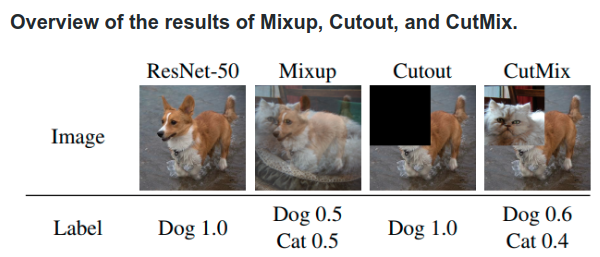

## CIFAR-10 데이터에 Augmentation 기법을 이용해 모델의 성능 향상시키기
---
- 이미지를 불러오는 부분에서 torchvision Module 내에 있는 transforms 함수를 이용하면 Augmentation을 쉽게 적용할 수 있음. 

In [1]:
'''1. Module Import'''

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets 

In [2]:
'''2. 딥러닝 모델을 설계할 때 활용하는 장비 확인'''

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version : ', torch.__version__, 'Device: ', DEVICE)

Using PyTorch version :  1.11.0 Device:  cuda


In [3]:
BATCH_SIZE = 32
EPOCH = 10

In [4]:
'''3. Data Augmentation이 적용된 CIFAR-10 데이터 다운로드 (train, test split)'''

train_dataset = datasets.CIFAR10(root="../data/CIFAR10",
                                train=True,
                                download=True,
                                transform=transforms.Compose([
                                    
                                    # 해당 이미지를 50%의 확률로 좌우 반전
                                    transforms.RandomHorizontalFlip(),
                                    
                                    # 0에서 1 사이의 값으로 정규화, Image -> Tensor 형태로 변환
                                    transforms.ToTensor(),
                                    
                                    # ToTensor() 형태로 전환도니 이미지에 대해 또 다른 정규화를 진행하는 것
                                    # 정규화 시 평균과 표준편차가 필요한데, rgb 순으로 평균을 0.5씩 적용
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         # rgb 순으로 표준편차를 0.5씩 적용
                                                        (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root="../data/CIFAR10",
                               train=False,
                               transform=transforms.Compose([
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5),
                                                       (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

Files already downloaded and verified


- 기본적으로 학습 데이터에 이용하는 전처리 과정은 검증 데이터에도 동일하게 적용되어야 모델의 성능을 평가할 수 있음. 

In [5]:
'''4. 데이터 확인하기 (1)'''

for (X_train, y_train) in train_loader:
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break

X_train:  torch.Size([32, 3, 32, 32]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

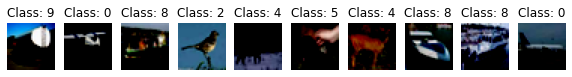

In [6]:
'''5. 데이터 확인하기 (2)'''

pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
'''6. Convolutional Neural Network(CNN) 모델 설계하기'''

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 2차원의 이미지 데이터를 nn.Conv2d 메서드를 이용해 Convolution하는 Filter를 정의
        self.conv1 = nn.Conv2d(in_channels=3,    # 채널 수를 이미지의 채널 수와 동일하게 맞춰야 함. rgb에 대해 동시에 conv 연산을 위함. 
                              out_channels=8,    # conv 연산을 진행하는 Filter의 개수 설정. Filter 개수만큼 Output의 depth가 정해짐. 
                              kernel_size=3,    # Filter의 크기를 설정
                              padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=8,    # 위에서 Filter Map의 Depth가 8이므로 채널 수 8로 설정
                              out_channels=16,
                              kernel_size=3,
                              padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2,
                                stride=2)
        
        self.fc1 = nn.Linear(8*8*16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8*8*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        
        return x

In [8]:
'''7. Optimizer, Objective Function 설정하기'''

model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [9]:
'''8. 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의'''

def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, 
                                                                                batch_idx*len(image),
                                                                               len(train_loader.dataset),
                                                                               100.*batch_idx/len(train_loader),
                                                                               loss.item()))

In [10]:
'''9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의'''

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [11]:
'''10. 모델 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기'''

for Epoch in range(1, EPOCH+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(Epoch,
                                                                                   test_loss,
                                                                                   test_accuracy))

/tmp/ipykernel_209/3354824684.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.311186
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.500085
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.413980
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.228132
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.520657
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.585394
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.493192
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.129480

[EPOCH: 1], 	Test Loss: 0.0415, 	Test Accuracy: 52.59 % 

Train Epoch: 2 [0/50000(0%)]	Train Loss: 0.975153
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.206834
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.463005
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.571416
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.245386
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.438663
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.140127
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.225110

[EPOCH: 2], 	Test Loss: 0.0374, 	Test Accuracy: 57.27 % 

Train Epoch: 3

- 기존에 비해 Test Accuracy가 아주 약간 올랐지만, 좀 더 다양하게 Augmentation을 적요하고 기존에 이용되는 데이터셋에 Augmentation 데이터셋을 추가로 이용해 학습 데이터셋의 양을 늘리면 모델의 성능이 좀 더 향상될 것이라 기대할 수 있음. 